In [178]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso,BayesianRidge, LogisticRegression,SGDClassifier
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR, SVC
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import torch
import ast
from joblib import dump, load
from sklearn.pipeline import Pipeline
import pickle
from IPython.display import Markdown

import os
import re
import torch.nn as nn
import random
plt.figure(dpi=150)
import cProfile
import torch
import torch.optim as optim
import torch.nn.utils as utils
import wandb
import pdb
from utils_suboptimal import *

<Figure size 960x720 with 0 Axes>

In [179]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
GRID_SIZE = 10
K = 8

# wandb.login(relogin=True)
# os.environ['WANDB_API_KEY'] = "71f0a53fa4cb62b56494f6554ec1a5e3b898a7dd"
# wandb.login(key="71f0a53fa4cb62b56494f6554ec1a5e3b898a7dd")

In [180]:
# Check if the WANDB_API_KEY is set
if "WANDB_API_KEY" in os.environ:
    print("Logged in with API key.")
    user_info = wandb.api.viewer()
    print("Current user:", user_info["entity"], user_info["username"])
else:
    print("Not logged in.")

Not logged in.


# CNN approach to predicting WCD

In [181]:
#f"simulated_valids_final{GRID_SIZE}.pkl"
if GRID_SIZE ==10:
    datasets = [
        f"archive-data/hyperbol_simulated_envs_K{K}_1.pkl",
        f"archive-data/hyperbol_simulated_envs_K{K}_2.pkl",
        f"archive-data/hyperbol_simulated_envs_K{K}_3.pkl",
        f"archive-data/hyperbol_simulated_envs_K{K}_4.pkl",
        f"archive-data/hyperbol_simulated_envs_K{K}_5.pkl",
        f"archive-data/hyperbol_simulated_envs_K{K}_6.pkl",
        f"archive-data/hyperbol_simulated_envs_K{K}_7.pkl",
        f"archive-data/hyperbol_simulated_envs_K{K}_8.pkl",
        f"hyperbol_simulated_envs_K{K}_0.pkl",
        f"simulated_valids_final10_K8.pkl"
    ]
elif GRID_SIZE == 6:
    datasets = [f"hyperbol_simulated_envs_K{K}_0.pkl",f"hyperbol_simulated_envs_K{K}_1.pkl",f"hyperbol_simulated_envs_K{K}_2.pkl",f"hyperbol_simulated_envs_K{K}_3.pkl", f"simulated_valids_final{GRID_SIZE}_ALL_MODS_K{K}.pkl",
           f"simulated_valids_final{GRID_SIZE}_BLOCKING_ONLY_K{K}.pkl",f"simulated_valids_final{GRID_SIZE}_BOTH_UNIFORM_K{K}.pkl",f"simulated_valids_final{GRID_SIZE}_K{K}.pkl"]
    
loaded_data = {}
dataset=datasets[0]
x_data = []
y_data = []
for dataset in datasets:
    if not os.path.exists(f"data/grid{GRID_SIZE}/model_training/{dataset}"): continue
    with open(f"data/grid{GRID_SIZE}/model_training/{dataset}", "rb") as f:
        loaded_dataset = pickle.load(f)
        print(dataset,len(loaded_dataset))
        for i in range(loaded_dataset. __len__()):
            x_i = loaded_dataset[i][0]
            if x_i.shape[0]==5:
                x_i = x_i[0:4,:,:]
                
            x_data.append(x_i.numpy())
            y_data.append(loaded_dataset[i][1].unsqueeze(0).item())


X = np.stack(x_data)[:,0:4,:,:]
Y = np.array(y_data)
X.shape, Y.shape

archive-data/hyperbol_simulated_envs_K8_1.pkl 38108


/storage1/fs1/chien-ju.ho/Active/robert/projects/Gridworld MDP/suboptimal/utils_suboptimal.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[idx], dtype=torch.float32)
/storage1/fs1/chien-ju.ho/Active/robert/projects/Gridworld MDP/suboptimal/utils_suboptimal.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.Y[idx], dtype=torch.float32)


archive-data/hyperbol_simulated_envs_K8_2.pkl 45591
archive-data/hyperbol_simulated_envs_K8_4.pkl 356872
archive-data/hyperbol_simulated_envs_K8_5.pkl 47074
archive-data/hyperbol_simulated_envs_K8_6.pkl 118488
archive-data/hyperbol_simulated_envs_K8_7.pkl 181903
archive-data/hyperbol_simulated_envs_K8_8.pkl 177317
hyperbol_simulated_envs_K8_0.pkl 177977
simulated_valids_final10_K8.pkl 49399


((1192729, 4, 10, 10), (1192729,))

Text(0.5, 0, 'WCD')

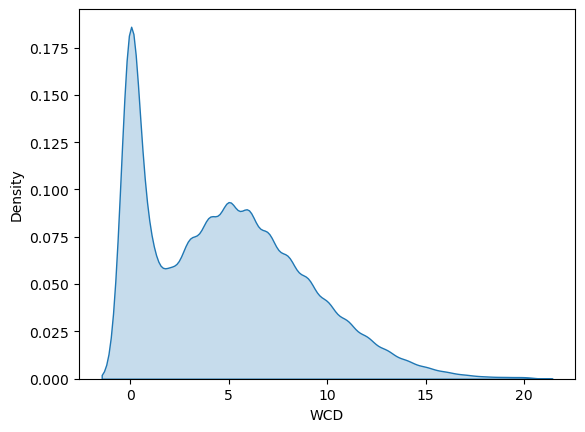

In [182]:
sns.kdeplot(Y,fill=True,bw_adjust=2)
plt.xlabel("WCD")

In [183]:
X.shape, Y.shape

((1192729, 4, 10, 10), (1192729,))

In [184]:
Y.mean(), Y.std()

(4.800657986852001, 3.9948361529647536)

In [185]:
def augment_data(chunk):
    augmented_chunk = np.concatenate([
        chunk,
        chunk[:, :, :, ::-1],        # Flip along the last axis
        chunk[:, :, ::-1, :],        # Flip along the second to last axis
        np.rot90(chunk, k=1, axes=(2, 3)), # Rotate 90 degrees
        np.rot90(chunk, k=3, axes=(2, 3)), # Rotate 270 degrees
        np.rot90(chunk, k=2, axes=(2, 3)), # Rotate 180 degrees
        chunk.transpose(0, 1, 3, 2)  # Transpose axes
    ])
    return augmented_chunk

# Assuming X and Y are already loaded into memory
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)
X, Y = None, None  # Free up memory

chunk_size = 2048*200 # Define the size of each chunk
num_chunks = len(x_train) // chunk_size + (1 if len(x_train) % chunk_size != 0 else 0)

x_train_path = "data/grid10/model_training/train_test/x_train.npy"
y_train_path = "data/grid10/model_training/train_test/y_train.npy"

# Open files for writing
x_train_file = open(x_train_path, 'wb')
y_train_file = open(y_train_path, 'wb')

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = min(start_idx + chunk_size, len(x_train))
    
    x_chunk = x_train[start_idx:end_idx]
    y_chunk = y_train[start_idx:end_idx]
    
    # Augment data
    x_augmented = augment_data(x_chunk)
    y_augmented = np.concatenate([y_chunk, y_chunk, y_chunk, y_chunk, y_chunk, y_chunk,y_chunk])
    
    # Save augmented data to file
    np.save(x_train_file, x_augmented)
    np.save(y_train_file, y_augmented)
    
    print(f'Processed chunk {i+1}/{num_chunks}')
    
# Close the files
x_train_file.close()
y_train_file.close()

n_channels = x_train.shape[1]
# Clear variables to free up memory
x_train, y_train, x_chunk, y_chunk, x_augmented, y_augmented = None, None, None, None, None, None

# Save the test data
np.save("data/grid10/model_training/x_test.npy", x_test)
np.save("data/grid10/model_training/y_test.npy", y_test)

Processed chunk 1/3
Processed chunk 2/3
Processed chunk 3/3


In [186]:
# x_train,x_test, y_train,y_test = train_test_split(X,Y, test_size=0.05)
# x_train = np.concatenate([x_train[:, :, :, ::-1],x_train,x_train[:, :, ::-1, :],np.rot90(x_train, k=1, axes=(2, 3)),
#                           np.rot90(x_train, k=3, axes=(2, 3)),np.rot90(x_train, k=2, axes=(2, 3)),
#                           x_train.transpose(0, 1, 3, 2)])

# y_train = np.concatenate([y_train,y_train,y_train,y_train,y_train,y_train,y_train])
# x_train.shape, x_test.shape

In [187]:
out_sample_set = CustomDataset(x_test,y_test)
with open(f"data/grid{GRID_SIZE}/model_training/dataset_{GRID_SIZE}_K{K}.pkl", "wb") as f:
    pickle.dump(out_sample_set, f)

In [188]:
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test, test_size=0.95, random_state=50)
x_val.shape, x_test.shape

((113310, 4, 10, 10), (5963, 4, 10, 10))

In [189]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import wandb

In [190]:
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(np.array(y_test)).float()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(np.array(y_val)).float()

In [191]:
class CustomCNN(nn.Module):
    def __init__(self, n_channels=13,drop_out = 0.01,size = 3):
        super(CustomCNN, self).__init__()

        # First block (no pooling)
        self.conv1 = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # Second block with pooling
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        # # Second block with pooling
        # self.conv3 = nn.Sequential(
        #     nn.Conv2d(256, 256, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.Conv2d(256, 512, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU()
        # )


        self.conv_output_size = 256 * size*size
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.conv_output_size, 16), # 3 for 6 & 7 
            nn.LeakyReLU(),
            # nn.Dropout(0.01),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(8, 1),
            nn.ReLU()
        )
        

    def forward(self, x):
        x = self.conv1(x)
        # pdb.set_trace()
        x = self.conv2(x)
        # x = self.conv3(x)
        # print(x.shape)
        x = x.view(-1, self.conv_output_size)
        x = self.fc_layers(x)
        return x

class CNN4(nn.Module):
    def __init__(self, n_channels=13,drop_out=0.01):
        super(CNN4, self).__init__()

        # Replace the first seven convolutional layers with ResNet50
        self.resnet50 = resnet18(pretrained=False)

        self.resnet50.conv1=self.conv1 = nn.Conv2d(n_channels, 64, kernel_size=3, stride=1, padding=1)
        self.resnet50.maxpool = nn.Identity()
        # self.resnet50.bn1 = nn.BatchNorm2d(8)

        # Keep the rest of the architecture as-is
        self.fc1 = nn.Linear(1000, 8)
        self.relu8 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.0001)

        self.fc2 = nn.Linear(8, 4)
        self.relu9 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(drop_out)

        self.fc3 = nn.Linear(4, 1)
        self.softplus = nn.functional.softplus
        self.reluN =nn.ReLU()

    def forward(self, x):
        x = self.resnet50(x)
        # pdb.set_trace()
        # print(x.shape)
        x = x.view(-1, 1000)
        
        x = self.fc1(x)
        x = self.relu8(x)


        x = self.fc2(x)
        x = self.relu9(x)
        x = self.dropout2(x)

        x = self.reluN(self.fc3(x))
        # x = self.softplus(self.fc4(x))

        return x

class CNN16(nn.Module):
    def __init__(self, n_channels=13,drop_out=0.01):
        super(CNN16, self).__init__()

        # Replace the first seven convolutional layers with ResNet50
        self.resnet50 = resnet18(pretrained=False)

        self.resnet50.conv1=self.conv1 = nn.Conv2d(n_channels, 64, kernel_size=3, stride=1, padding=1)
        self.resnet50.maxpool = nn.Identity()
        # self.resnet50.bn1 = nn.BatchNorm2d(8)

        # Keep the rest of the architecture as-is
        self.fc1 = nn.Linear(1000, 16)
        self.relu8 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.0001)

        self.fc2 = nn.Linear(16, 8)
        self.relu9 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(drop_out)

        self.fc3 = nn.Linear(8, 1)
        self.softplus = nn.functional.softplus
        self.reluN =nn.ReLU()

    def forward(self, x):
        x = self.resnet50(x)
        # pdb.set_trace()
        # print(x.shape)
        x = x.view(-1, 1000)
        
        x = self.fc1(x)
        x = self.relu8(x)


        x = self.fc2(x)
        x = self.relu9(x)
        x = self.dropout2(x)

        x = self.reluN(self.fc3(x))
        # x = self.softplus(self.fc4(x))

        return x

In [192]:
def evaluate_and_log(best_model, x_val, y_val, epoch, wandb=None):
    def predict_in_batches(model, x, batch_size):
        n_batches = len(x) // batch_size + (len(x) % batch_size != 0)
        all_preds = []
        
        for i in range(n_batches):
            x_batch = x[i * batch_size: (i + 1) * batch_size]
            preds_batch = model(x_batch.cuda()).detach()
            all_preds.append(preds_batch)
        
        return torch.cat(all_preds, dim=0).cpu()

    val_pred = predict_in_batches(best_model, x_val, 1024)  # Adjust batch size as per memory needs
    
    if wandb:
        wandb.log({
            "epoch": epoch,
            "mse_val_small": nn.MSELoss()(val_pred[y_val <= GRID_SIZE/2], y_val.view(-1, 1)[y_val <= GRID_SIZE/2]).item(),
            "mse_val_big": nn.MSELoss()(val_pred[y_val > GRID_SIZE/2], y_val.view(-1, 1)[y_val > GRID_SIZE/2]).item(),
            "mse_val_loss": nn.MSELoss()(val_pred, y_val.view(-1, 1)).item(),
            "val_loss": nn.HuberLoss()(val_pred, y_val.view(-1, 1)).item(),
            "valid_mean_wcd": val_pred[y_val != INVALID_WCD].mean(),
            "invalid_mean_wcd": val_pred[y_val == INVALID_WCD].mean(),
            "valid_h_loss": nn.HuberLoss()(val_pred[y_val != INVALID_WCD], y_val.view(-1, 1)[y_val != INVALID_WCD]).item(),
            "invalid_h_loss": nn.HuberLoss()(val_pred[y_val == INVALID_WCD], y_val.view(-1, 1)[y_val == INVALID_WCD]).item(),
            "valid_mse_loss": nn.MSELoss()(val_pred[y_val != INVALID_WCD], y_val.view(-1, 1)[y_val != INVALID_WCD]).item(),
            "invalid_mse_loss": nn.MSELoss()(val_pred[y_val == INVALID_WCD], y_val.view(-1, 1)[y_val == INVALID_WCD]).item(),
        })
    return nn.HuberLoss()(val_pred, y_val.view(-1, 1)).item() ,nn.MSELoss()(val_pred, y_val.view(-1, 1)).item()

In [193]:
# batch_size = 1024//2 #512 for smaller (6,7,8)
# dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(np.array(y_train)).float())
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [194]:
class NpyDataset(Dataset):
    def __init__(self, x_file, y_file, chunk_size=2048):
        self.x_data = np.load(x_file, mmap_mode='r')
        self.y_data = np.load(y_file, mmap_mode='r')
        self.chunk_size = chunk_size

        assert len(self.x_data) == len(self.y_data), "Mismatch in X and Y lengths"

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x_sample = self.x_data[idx]
        y_sample = self.y_data[idx]

        # Ensure the data has the correct dimensions
        x_sample = np.expand_dims(x_sample, axis=0)  # Add channel dimension if needed

        return torch.tensor(x_sample, dtype=torch.float32).squeeze(0), torch.tensor(y_sample, dtype=torch.float32)


# Usage
x_file_path = 'data/grid10/model_training/train_test/x_train.npy'
y_file_path = 'data/grid10/model_training/train_test/y_train.npy'
chunk_size = 2048

dataset = NpyDataset(x_file_path, y_file_path, chunk_size=chunk_size)
dataloader = DataLoader(dataset, batch_size=chunk_size, shuffle=True,num_workers =4)

In [195]:
if GRID_SIZE in [6,7,8]:
    dropout = 0.1
    lambda_l2 =0.0 #0.1 regularization strength
    grad_clip =1e-3 # 1e-3 for 6,7,8
    lr=0.001 #0.005 for 6,7,8
    num_epochs = 10# 3 for 6,7,8
else:
    dropout = 0.5
    lambda_l2 = 1 #0.1 regularization strength
    grad_clip =1e-3 # 1e-3 for 6,7,8
    lr=0.001 #0.005 for 6,7,8
    num_epochs = 20# 3 for 6,7,8


In [196]:
# model = CustomCNN(n_channels=x_train.shape[1],drop_out=dropout,size = GRID_SIZE//2).cuda() #GRID_SIZE//2
model = CNN4(n_channels=x_test.shape[1],drop_out=dropout).cuda() #
# model = torch.load("models/wcd_nn_oracle_july6.pt")

/home/k.robert/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/k.robert/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [197]:
# # init_model = torch.load("models/wcd_10_init.pt")
init_model = torch.load(f"models/wcd_nn_model_10_K4_best.pt") 

model = init_model
model.dropout1 = nn.Dropout(dropout)

In [198]:
total_params = 0
for parameter in model.parameters():
    # print(parameter.shape)
    total_params += parameter.numel()  # numel() returns the total number of elements in the tensor

print(f"Total number of parameters: {total_params}") #636673

Total number of parameters: 11698633


In [199]:
# model = VGGNet(n_channels = x_train.shape[1]).cuda()

Starting Training
5.204107284545898
4.380393981933594
Val 1 4.305889129638672
3.4356870651245117
3.5523338317871094
Val 3 4.041098117828369
3.5748772621154785
3.0250582695007324
Val 5 3.885674238204956
3.1208958625793457
2.849114418029785
Val 7 3.921125888824463
2.7798516750335693
3.085690975189209
Val 9 3.8988802433013916
2.6944422721862793
2.6701138019561768
Val 11 3.9673004150390625
2.3617870807647705
2.124331474304199
Val 13 4.090606689453125
2.503791570663452
2.023668050765991
Val 15 4.18707799911499
2.0468380451202393
2.078791618347168
Val 17 4.261697769165039
1.9971163272857666
1.8275350332260132
Val 19 4.195367336273193


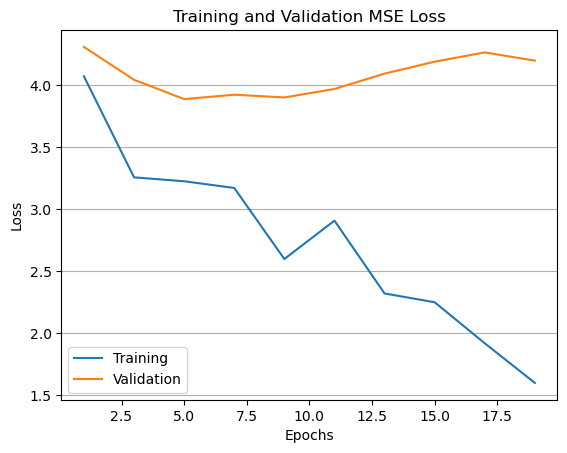

In [200]:
use_wandb = False
if use_wandb:
    wandb.init(project='gridworld', save_code=False, config={"lambda_l2": lambda_l2, "grad_clip":grad_clip,
                                                              "n_train":x_train.shape[0],"GRID_SIZE":GRID_SIZE,"dropout":dropout,
                                                              "lr":lr,"batch_size":batch_size, "experiment":"gridworld"})
# create dataset and dataloader
# initialize model and optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12,25,45,55], gamma=0.5)

# training loop

best_model = model
log_interval = 2

def train():
    training_loss = []
    val_mse_loss =[]
    val_huber_loss = []
    x_epochs = []
    
    lowest_loss = torch.inf
    for epoch in range(num_epochs):
        for i, (inputs, targets) in enumerate(dataloader):
            optimizer.zero_grad()
            
            # print(inputs[:,0,:,:].mean())
            # forward pass
            outputs = model(inputs.cuda())
            # targets = targets.cuda()

            # compute loss and perform backpropagation
            y_true = targets.view(-1, 1).cuda()
            loss = nn.MSELoss()(outputs, y_true)
            mse_loss = loss.item()
            
            # l2_reg = lambda_l2 * torch.norm(torch.cat([p.view(-1) for p in model.parameters()]), p=2)  # L2 regularization term
            # loss += l2_reg
            
            loss.backward()
            utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            if loss < lowest_loss:
                lowest_loss = loss.item()
                best_model = model
            
            if (i + 1) % 1000*log_interval == 0:
                if use_wandb:
                    wandb.log({"loss": mse_loss})
                print(mse_loss)
                

        if (epoch + 1) % log_interval == 0:
            val_huber,val_mse = evaluate_and_log(best_model, x_val, y_val, epoch, wandb=wandb if use_wandb else None )
            val_mse_loss.append(val_mse)
            val_huber_loss.append(val_huber)
            training_loss.append(mse_loss)
            x_epochs.append(epoch)
            print("Val",epoch,val_mse)
            
            # plt.plot(x_epochs,training_loss, label="Training")
            # plt.plot(x_epochs,val_mse_loss, label="Validation")
            # plt.show()
            
        scheduler.step()
        torch.save(best_model, f"models/wcd_nn_model_{GRID_SIZE}_K{K}.pt")
    plt.plot(x_epochs,training_loss, label="Training")
    plt.plot(x_epochs,val_mse_loss, label="Validation")

    # Adding labels
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation MSE Loss")

    # Setting y-axis limits and grid lines in intervals of 5
    # plt.ylim(0, 30)
    # plt.yticks(range(0, 21, 5))
    plt.grid(axis='y')

    plt.legend()
    plt.show()
print('Starting Training')
# Start profiling
profiler = cProfile.Profile()
profiler.enable()

# Run the training loop
train()

# Stop profiling
profiler.disable()
# profiler.print_stats()

wandb.finish()


In [201]:
# nn.MSELoss()(best_model(x_test),y_test.view(-1, 1))

In [202]:
nn.HuberLoss()(best_model(x_test),y_test.view(-1, 1).cuda())

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
torch.mean(abs(best_model(x_test)-y_test.view(-1, 1)))

In [ ]:
torch.mean(abs(best_model(x_test)-y_test.view(-1, 1)))

In [ ]:
sns.kdeplot(best_model(x_test).cpu().detach().numpy(), fill=True,label="Pred")
sns.kdeplot(y_test.view(-1, 1).cpu().detach().numpy(), fill=True,label="True")
plt.legend()

In [ ]:
torch.save(best_model,f"models/wcd_nn_oracle_{GRID_SIZE}.pt")

In [ ]:
x_test.shape